### Was a web re-design a success?
#### Background
A team belives a new design will increase the number of people who click through and join a website. They have been testing the changes for a few weeks, and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if its statistically significant.

#### The data

##### Redesign test data
- treatment - 'yes' if the user saw the new version of the landing page 'no' otherwise.
- 'new_images' - 'yes' if the used a new set of images, 'no' otherwise.
- 'converted' - 1 if joined the site, 0 otherwise.
- The control group is those users with 'no' in both columns: the old version with the old set of images.

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('C:\\Users\\DELL\\Desktop\\my work')

In [2]:
df = pd.read_csv('redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


#### Exploratory analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


- we see that there are no misssing values for all the columns

In [4]:
df['treatment'].value_counts()

treatment
yes    20242
no     20242
Name: count, dtype: int64

- A 50/50 allocation between the treatment and control groups

In [5]:
pd.crosstab(df['treatment'], df['new_images'])

new_images,no,yes
treatment,,
no,10121,10121
yes,10121,10121


- A proper balance in the dataset variations for the treatment and control groups for the new and old website.
- since the data is neat and clean, Lets prepare the data for further analysis
#### Next lets generate groups for different users from columns: web version and set of images.

In [6]:
df['group'] = df.apply(lambda x: 'A' if (x['treatment']=='yes') & (x['new_images']=='yes')
                       else ('B' if (x['treatment']=='yes') & (x['new_images']=='no')
                             else( 'C' if (x['treatment']=='no') & (x['new_images']=='yes')
                                  else 'control')), axis=1) 
df.head()

,treatment,new_images,converted,group
0,yes,yes,0,A
1,yes,yes,0,A
2,yes,yes,0,A
3,yes,no,0,B
4,no,yes,0,C


##### explaining the new column we created.
- A- these are observations from users who have seen the new set of images and new design of the landing page
- B- these are observations from users who have seen the old set of images and new design of the landing page
- C- these are observations from users who have seen the new set of images and old design of the landing page

- control - these are observations from users who have seen the old set of images and old design of the landing page

######
#### Lets analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures


In [9]:
conv_diff = df.groupby('group')['converted'].agg({'mean', 'std'}).reset_index()
conv_diff = conv_diff.rename(columns={'mean':'conversion_rate'})
conv_diff 

,group,std,conversion_rate
0,A,0.317491,0.113724
1,B,0.325033,0.120047
2,C,0.316043,0.112538
3,control,0.309261,0.107104


- we can see that group B has a slightly higher conversion rate compared to other groups.
- Next, we shall have to evaluate if these conversions are not by chance. 
- but lets first plot the conversion rates.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

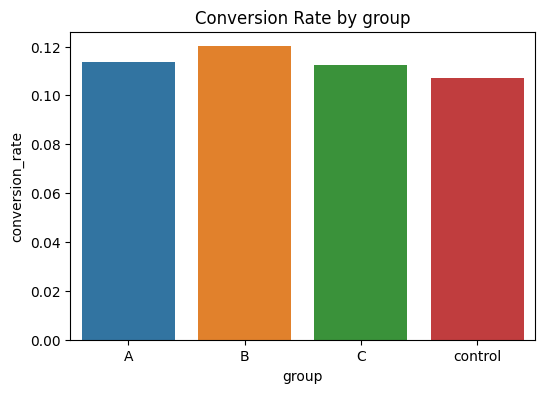

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(data=conv_diff, y='conversion_rate', x='group', hue='group')
plt.title('Conversion Rate by group')
plt.show()

#### Analyzing the difference in proportions A/B tests
##### To evaluate whether the difference in the mean conversion rate between groups are statistically significant,
- we need to perform a two sample z-test for proportions 
- This allows us to calculate the p-value of the test.
- if p-value < alpha, reject the null hypothesis and conclude that the treatment effect is statistically significant.
  - if p-value > alpha, fail to reject null hypothesis
- to get an estimate for conversion rate, we lean on the concept of confidence intervals.
95% Confidence Interval is the range of plausible values that captures the true difference 95% of the time and is centered around the observed differnce between the treatment and control.
###### 
- we shall split the dataframe into four subgroups
- concate each of the subgroups to the control group
- Then we shall compare the conversion rate for each group to the control group

In [13]:
# spliting into sub groups
A_df = df[df['group']=='A']
B_df = df[df['group']=='B']
C_df = df[df['group']=='C']
control_df = df[df['group']=='control']

# concatenating one by one with the control group dataframe
A_con = pd.concat([A_df, control_df], axis=0)
B_con = pd.concat([B_df, control_df], axis=0)
C_con = pd.concat([C_df, control_df], axis=0)


##### Two sample proportions z-test

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [15]:
#  the number of users per group
n_A = A_df['converted'].count()
n_B = B_df['converted'].count()
n_C = C_df['converted'].count()
n_con = control_df['converted'].count()

print('Group A users:', n_A)
print('Group B users:', n_B)
print('Group C users:', n_C)
print('control group users:', n_con)

Group A users: 10121
Group B users: 10121
Group C users: 10121
control group users: 10121


In [16]:
# successes in each group
success_A = A_df['converted'].sum()
success_B = B_df['converted'].sum()
success_C = C_df['converted'].sum()
success_con = control_df['converted'].sum()

print('Group A success:', success_A)
print('Group B success:', success_B)
print('Group C success:', success_C)
print('control group success:', success_con)

Group A success: 1151
Group B success: 1215
Group C success: 1139
control group success: 1084


In [17]:
# Assign groups list
# 1. group A vs control group
success_A_con = [success_A, success_con]
nobs_A_con = [n_A, n_con]

# 2. group A vs control group
success_B_con = [success_B, success_con]
nobs_B_con = [n_B, n_con]

# 3. group A vs control group
success_C_con = [success_C, success_con]
nobs_C_con = [n_C, n_con]



##### performing the full set of comparisions between the three designs,

In [18]:
# 1. group A vs control group
z_stat, pvalue = proportions_ztest(success_A_con, nobs=nobs_A_con)
(A_lo95, con_lo95), (A_up95, con_up95) = proportion_confint(success_A_con, nobs=nobs_A_con, alpha=0.05)

#print the p-value and confidence intervals
print(f'p-value:{pvalue:.4f}')
print(f'Group A 95% CI:[{A_lo95:.4f}, {A_up95:.4f}]')
print(f'control group 95% CI:[{con_lo95:.4f}, {con_up95:.4f}]')

p-value:0.1329
Group A 95% CI:[0.1075, 0.1199]
control group 95% CI:[0.1011, 0.1131]


In [19]:
 # group B vs control group
z_stat, pvalue = proportions_ztest(success_B_con, nobs=nobs_B_con)
(B_lo95, con_lo95), (B_up95, con_up95) = proportion_confint(success_B_con, nobs=nobs_B_con, alpha=0.05)

#print the p-value and confidence intervals
print(f'p-value:{pvalue:.4f}')
print(f'Group B 95% CI:[{A_lo95:.4f}, {A_up95:.4f}]')
print(f'control group 95% CI:[{con_lo95:.4f}, {con_up95:.4f}]')

p-value:0.0037
Group B 95% CI:[0.1075, 0.1199]
control group 95% CI:[0.1011, 0.1131]


In [20]:
 # group C vs control group
z_stat, pvalue = proportions_ztest(success_C_con, nobs=nobs_C_con)
(C_lo95, con_lo95), (C_up95, con_up95) = proportion_confint(success_C_con, nobs=nobs_C_con, alpha=0.05)

#print the p-value and confidence intervals
print(f'p-value:{pvalue:.4f}')
print(f'Group C 95% CI:[{A_lo95:.4f}, {A_up95:.4f}]')
print(f'control group 95% CI:[{con_lo95:.4f}, {con_up95:.4f}]')

p-value:0.2163
Group C 95% CI:[0.1075, 0.1199]
control group 95% CI:[0.1011, 0.1131]


#### Results
Running the Z-test on the three variations, each against the control group, the significance of each conversion rate is shown:
- A/B test on group A vs control has a p-value of 0.1329 which is way bigger than the alpha of 0.05. this means we fail to reject the null hypothesis.
- A/B test on group B vs control has a p-value of 0.0037 which is smaller than the alpha of 0.05. this means we  reject the null hypothesis.
- A/B test on group A vs control has a p-value of 0.2163 which is way bigger than the alpha of 0.05. this means we fail to reject the null hypothesis.
- Looking at the confidence interval of group B we expect the conversion rate to lie between 10 - 11 percent with 95% confidence.

#### Conclusions
The data didnot support the increase in conversion rates statistically for the following variations:
1. New version of landing page and new images
2. Old version of landing page and new set of images.
######
However one variation had a statistical significance in terms of conversion rate and is supported by the data analysed above.
- The variation (New design of landing page and old set of images) has a p-value of 0.0037 which is way smaller than alpha 0.05, thus we reject the null hypothesis that the two groups have equal conversion rates, and we can expect a conversion rate to lie between 10-11% with 95% confidence.

##### Therefore, the company should proceed to use the new design of the landing page with the old set of images on the website.
##### Thankyou for giving my project a detailed look. please feel free to leave a comment or suggestion to mawadripaul111@gmail.com